{'k': 1.5, 'D': 0.2, 'v': 1, 'tau': 0.8, 'R': 0.3, 'label': 'default'}

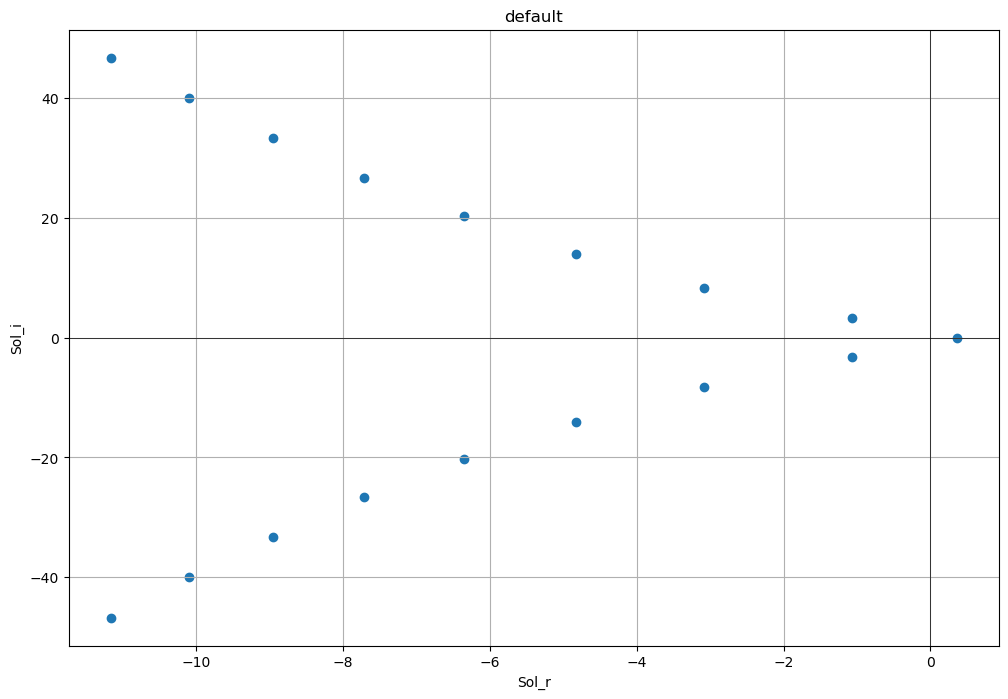

{'par': {'k': 1.5; 'D': 0.2; 'v': 1; 'tau': 0.8; 'R': 0.3; 'label': 'default'}; 'guess_range': ([-20; 5; 5]; [0; 50; 25]); 'tols': (1e-09; 1e-06; 4)}


In [1]:
import os
import numpy as np
from functions import *
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve
import scipy.signal as signal
import scipy.linalg as lina
import matplotlib.cm as cm
# Get the viridis colormap
# my_cmap = cm.get_cmap('viridis')


# Get the directory where the current script is located
script_directory = os.getcwd()

# Change the current working directory to the script's directory
os.chdir(script_directory)

# Now the CWD is the same as the script's directory
# print("New Current Working Directory:", os.getcwd())

default_pars = obtain_default_pars('pars_list.csv')
# display(default_pars)

pars_list = create_custom_pars_list('pars_list.csv')
par = default_pars
# par = pars_list[0] # between 0 - 3; 1 is good; 3 to compare
display(par)

path_maker = par['label']
path = f"CSV/{path_maker}.csv"

if not os.path.exists(path):
    guess = {
        'guess_range_real':[-20,5,5],
        'guess_range_imag':[0,50,25]
    }
    save_dataframe_to_csv(*find_eig(par, **guess, round_sig_digits=4, tol_is_sol=1e-6, max_iter=200), 'CSV')
# else:
    # print("Solution has already been saved in the appropriate location.")

df, label, metadata = plot_single_df(
        path, filter=True,
        real_lower_bound=-40, real_upper_bound=5, imag_lower_bound=-500, imag_upper_bound=500
)
n_lambdas = len(df)
# display(df.head(n_lambdas))

from scipy.integrate import quad

lambdas = []
for index, row in df.head(n_lambdas).iterrows():
    l = complex(row['Sol_r'], row['Sol_i'])
    # print(f'lambda_{index+1} = {l}')
    lambdas.append(l)

normal_coefs = []
for n in range(n_lambdas):
    l = lambdas[n]
    
    i_phi = quad(eig_fun_mul_0,0,1,args=(par, l),complex_func=True)[0]
    b_phi = np.sqrt(1/i_phi)
    
    i_psi = quad(eig_fun_mul_1,0,1,args=(par, l, [b_phi, 1]),complex_func=True)[0]
    b_psi = (1/i_psi)
    
    b = (b_phi, b_psi.conjugate())
    normal_coefs.append(b)
    
    # print(f'normal_coef_phi_{n+1} = {complex(round(normal_coefs[n][0].real,4),round(normal_coefs[n][0].imag,4))}')
    # print(f'normal_coef_psi_{n+1} = {complex(round(normal_coefs[n][1].real,4),round(normal_coefs[n][1].imag,4))}')
    # print()

In [2]:
from scipy.integrate import solve_ivp
import plotly.graph_objs as go

N_zeta = 100
zeta = np.linspace(0,1,N_zeta)
dz = zeta[1]
phi_1_0 = init_cond_func_1(zeta)
phi_2_0 = init_cond_func_2(zeta, par)
x_0 = np.array([phi_1_0, phi_2_0])
# np.random.seed(42)  # Set the seed for reproducibility
# noise = np.random.normal(0, 0.25, size=x_0.shape)
x_hat_0 = np.ones_like(x_0) * 0.1

In [3]:
t_end = 8
N_t_d = 5*t_end

n_modes=3

In [4]:
t_eval_d = np.linspace(0,t_end,N_t_d+1)
s = 2/t_eval_d[1]
# G, S, S_u = G_S_Su(zeta, s, par, q_ctrl, N, r_ctrl, lambdas, n_modes, normal_coefs)
print(f't_eval_d = {t_eval_d[0]}, {t_eval_d[1]}, ... , {t_eval_d[-1]}')
# find_smallest_r(G, r_ctrl, 0, 5*r_ctrl)

t_eval_d = 0.0, 0.2, ... , 8.0


In [5]:
N = 15
q_ctrl = 1
r_ctrl = 2000

u_limits = [-0.005,0.15]
# y_limits = [-0.2,0.2]

G, S, S_u = G_S_Su(zeta, s, par, q_ctrl, N, r_ctrl, lambdas, n_modes, normal_coefs)

import quadprog
x_MPC = []
x_hat_MPC = []
U_MPC = []
results_MPC = []
x_MPC.append(x_0)
x_hat_MPC.append(x_hat_0)
y_MPC = []
y_hat_MPC = []

L = np.ones(2*N_zeta) * 1
# L = np.linspace(1,0,2*N_zeta) * 2.5

L = L.reshape((2,N_zeta))

nnn = len(t_eval_d)
for i in range(nnn):

    alpha = np.exp(-1.8 * i / nnn) # compare convergence to stable observer error
    x_hat_MPC[i] = x_hat_MPC[i] * alpha + x_MPC[i] * (1 - alpha)
    
    G, a, C, b, meq = MPC_matrix_build(
            x_hat_MPC[i], s, par,
            lambdas, normal_coefs, q_ctrl, G, S, S_u,
            n_modes=n_modes, N=N,
            u_limits=u_limits, y_limits=(-1000, 1000),
            meq=1
        )
    # display(G, a, C, b, meq)
    results_MPC.append(quadprog.solve_qp(G, a, C, b, meq))
    U_MPC.append(results_MPC[i][0][0])
    
    y_MPC.append(C_d(x_MPC[i], s, par) + D_d(zeta, s, par) * U_MPC[i])
    y_hat_MPC.append(C_d_obs(x_hat_MPC[i], s, par, L) + D_d_obs(L, s, par) * U_MPC[i] + M_d_obs(L, s, par) * y_MPC[i])

    x_MPC.append(A_d(x_MPC[i], s, par)[:,:,-1] + B_d(zeta, s, par, u=U_MPC[i]))
    x_MPC[-1][1,-1] = x_MPC[-1][0,-1].copy()
    
    x_hat_MPC.append(A_d(x_hat_MPC[i], s, par)[:,:,-1] + B_d(zeta, s, par, u=U_MPC[i]) + L_d(L, s, par) * (y_MPC[i] - y_hat_MPC[i]))
    x_hat_MPC[-1][1,-1] = x_hat_MPC[-1][0,-1].copy()
    
    # print(np.round(results_MPC[i][0],3))
    print(f"u(t) = {results_MPC[i][0][0]:.4f} obtained at t = {t_eval_d[i] + t_eval_d[1]:.2f} s")
    # print(f"y(t) = {y_MPC[i]:.2f} and y_hat(t) = {y_hat_MPC:.2f} obtained at t = {t_eval_d[i] + t_eval_d[1]:.2f} s")

x_MPC = np.transpose(np.array(x_MPC[:-1]),(1,2,0))
x_hat_MPC = np.transpose(np.array(x_hat_MPC[:-1]),(1,2,0))

U_MPC = np.array([0] + U_MPC[:-1])
t_eval_d *= 100

# import quadprog
# x_MPC = []
# U_MPC = []
# results_MPC = []
# x_MPC.append(x0)
# for i in range(len(t_eval_d)):
#     G, a, C, b, meq = MPC_matrix_build(
#             x_MPC[i], s, par, 
#             lambdas, normal_coefs, q_ctrl, G, S, S_u,
#             n_modes=n_modes, N=N,
#             u_limits=u_limits, y_limits=(-1000, 1000),
#             meq=1
#         )
#     # display(G, a, C, b, meq)
#     results_MPC.append(quadprog.solve_qp(G, a, C, b, meq))
#     U_MPC.append(results_MPC[i][0][0])
#     x_MPC.append(A_d(x_MPC[i], s, par)[:,:,-1] + B_d(zeta, s, par, u=U_MPC[i]))
#     x_MPC[-1][1,-1] = x_MPC[-1][0,-1].copy()
#     print(f"u(t) = {results_MPC[i][0][0]:.4f} obtained at t = {t_eval_d[i] + t_eval_d[1]:.2f} s")

# x_MPC = np.transpose(np.array(x_MPC[:-1]),(1,2,0))
# U_MPC = np.array([0] + U_MPC[:-1])


u(t) = 0.0324 obtained at t = 0.20 s
u(t) = 0.0498 obtained at t = 0.40 s
u(t) = 0.0881 obtained at t = 0.60 s
u(t) = 0.1239 obtained at t = 0.80 s
u(t) = 0.1478 obtained at t = 1.00 s
u(t) = 0.1500 obtained at t = 1.20 s
u(t) = 0.1500 obtained at t = 1.40 s
u(t) = 0.1472 obtained at t = 1.60 s
u(t) = 0.1292 obtained at t = 1.80 s
u(t) = 0.1091 obtained at t = 2.00 s
u(t) = 0.0906 obtained at t = 2.20 s
u(t) = 0.0745 obtained at t = 2.40 s
u(t) = 0.0612 obtained at t = 2.60 s
u(t) = 0.0506 obtained at t = 2.80 s
u(t) = 0.0417 obtained at t = 3.00 s
u(t) = 0.0348 obtained at t = 3.20 s
u(t) = 0.0292 obtained at t = 3.40 s
u(t) = 0.0245 obtained at t = 3.60 s
u(t) = 0.0211 obtained at t = 3.80 s
u(t) = 0.0183 obtained at t = 4.00 s
u(t) = 0.0161 obtained at t = 4.20 s
u(t) = 0.0145 obtained at t = 4.40 s
u(t) = 0.0130 obtained at t = 4.60 s
u(t) = 0.0118 obtained at t = 4.80 s
u(t) = 0.0107 obtained at t = 5.00 s
u(t) = 0.0097 obtained at t = 5.20 s
u(t) = 0.0089 obtained at t = 5.40 s
u

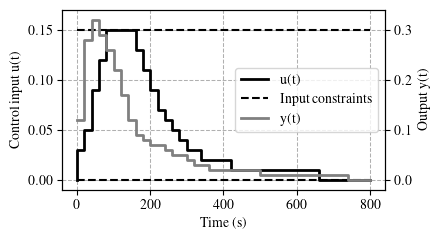

In [7]:
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)

# Create a figure for the input u(t) and output y(t) plots
plt.figure(figsize=(4.5, 2.5))

# Primary y-axis for u(t)
ax1 = plt.gca()
line1 = ax1.step(t_eval_d, np.round(U_MPC, 2), where='pre', color='black', linewidth=2, label='u(t)')
line2 = ax1.plot(t_eval_d, np.round(np.ones_like(t_eval_d) * u_limits[0], 2), 'k--', label='Input constraints')
line3 = ax1.plot(t_eval_d, np.round(np.ones_like(t_eval_d) * u_limits[1], 2), 'k--')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Control input u(t)', color='black')
ax1.grid(which='both', linestyle='--', linewidth=0.75)

# Setting major locators
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

# Secondary y-axis for y(t)
ax2 = ax1.twinx()
line4 = ax2.step(t_eval_d, np.round(y_MPC, 2), where='post', color='gray', linewidth=2, label='y(t)')
ax2.set_ylabel('Output y(t)')
ax1.set_ylim(-0.01, 0.17)
ax2.set_ylim(-0.02, 0.34)
# Combine legends
lines = line1 + line2 + line4  # Combining all lines
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')
plt.savefig('input.svg', format='svg', bbox_inches='tight', pad_inches=0.5)
plt.tight_layout()

plt.show()


In [11]:
U_MPC = U_MPC[:31]
x_MPC = x_MPC[:,:,:31]
x_hat_MPC = x_hat_MPC[:,:,:31]
y_MPC = y_MPC[:31]
y_hat_MPC = y_hat_MPC[:31]
t_eval_d = t_eval_d[:31]

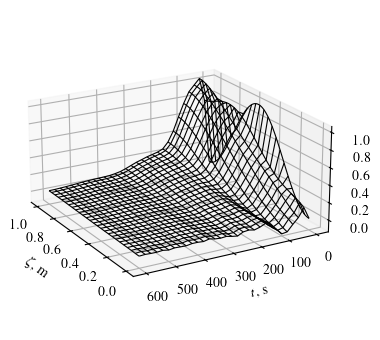

In [24]:
# Set Times font for the plot
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
# Create t_grid and z_grid for meshgrid
t_grid, z_grid = np.meshgrid(t_eval_d, zeta)

# Create a figure for xd[0] and xd[1] wireframe plots
fig = plt.figure(figsize=(3.5,3.5))
azim_angle = 150
elev_angle = 20
# Plot xd[0]
ax1 = fig.add_subplot(111, projection='3d')
ax1.view_init(elev= elev_angle, azim=azim_angle)  # For xd[0] plot
ax1.plot_wireframe(z_grid, t_grid, x_MPC[0], color='black', linewidth=0.8, rstride=4, cstride=1)
ax1.set_ylabel(r'$t$, s')
ax1.set_xlabel(r'$\zeta$, m')
ax1.set_zlabel(r'$x_1(\zeta, t)$, M')
# ax1.set_title(r'Open-loop Response $x_1(\zeta, t)$')
ax1.set_box_aspect([2, 2, 1])  # Aspect ratio for width, height, depth

# Plot xd[1]
# ax2 = fig.add_subplot(212, projection='3d')
# ax2.view_init(azim=azim_angle)  # For xd[1] plot
# ax2.plot_wireframe(z_grid, t_grid, x_MPC[1], color='black', linewidth=0.8, rstride=3, cstride=1)
# ax2.set_ylabel(r'$t$, s')
# ax2.set_xlabel(r'$\zeta$, m')
# ax2.set_zlabel(r'$x_2(\zeta, t)$, M')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig('closedloop_response.svg', format='svg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [ ]:
# Set Times font for the plot
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
# t_eval_d *= 100
# Create t_grid and z_grid for meshgrid
t_grid, z_grid = np.meshgrid(t_eval_d, zeta)

# Create a figure for xd[0] and xd[1] wireframe plots
fig = plt.figure(figsize=(5,5))
azim_angle = 150
# Plot xd[0]
ax1 = fig.add_subplot(111, projection='3d')
ax1.view_init(azim=azim_angle)  # For xd[0] plot
ax1.plot_wireframe(z_grid, t_grid, x_hat_MPC[0], color='black', linewidth=0.8, rstride=3, cstride=1)
ax1.set_ylabel(r'$t$, s')
ax1.set_xlabel(r'$\zeta$, m')
ax1.set_zlabel(r'$\hat{x}_1(\zeta, t)$, M')
# ax1.set_title(r'Open-loop Response $x_1(\zeta, t)$')

# Plot xd[1]
# ax2 = fig.add_subplot(212, projection='3d')
# ax2.view_init(azim=azim_angle)  # For xd[1] plot
# ax2.plot_wireframe(z_grid, t_grid, x_MPC[1], color='black', linewidth=0.8, rstride=3, cstride=1)
# ax2.set_ylabel(r'$t$, s')
# ax2.set_xlabel(r'$\zeta$, m')
# ax2.set_zlabel(r'$x_2(\zeta, t)$, M')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig('reconstructed_state.svg', format='svg', bbox_inches='tight', pad_inches=0.5)
plt.show()



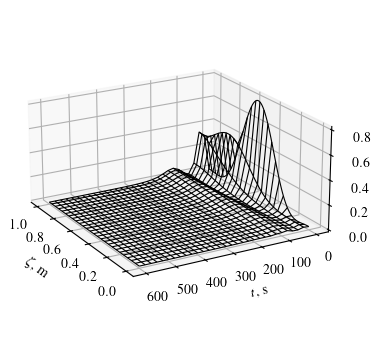

In [26]:
# Set Times font for the plot
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
# t_eval_d *= 100
# Create t_grid and z_grid for meshgrid
t_grid, z_grid = np.meshgrid(t_eval_d, zeta)

# Create a figure for xd[0] and xd[1] wireframe plots
fig = plt.figure(figsize=(3.5,3.5))
azim_angle = 150
elev_angle = 20
# Plot xd[0]
ax1 = fig.add_subplot(111, projection='3d')
ax1.view_init(elev= elev_angle, azim=azim_angle)  # For xd[0] plot
ax1.plot_wireframe(z_grid, t_grid, (x_MPC[0] - x_hat_MPC[0])**2, color='black', linewidth=0.8, rstride=4, cstride=1)
ax1.set_ylabel(r'$t$, s')
ax1.set_xlabel(r'$\zeta$, m')
ax1.set_zlabel(r'$err_{obs}(\zeta, t)$, M')
# ax1.set_title(r'Open-loop Response $x_1(\zeta, t)$')
ax1.set_box_aspect([2, 2, 1])  # Aspect ratio for width, height, depth

# Plot xd[1]
# ax2 = fig.add_subplot(212, projection='3d')
# ax2.view_init(azim=azim_angle)  # For xd[1] plot
# ax2.plot_wireframe(z_grid, t_grid, x_MPC[1], color='black', linewidth=0.8, rstride=3, cstride=1)
# ax2.set_ylabel(r'$t$, s')
# ax2.set_xlabel(r'$\zeta$, m')
# ax2.set_zlabel(r'$x_2(\zeta, t)$, M')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig('observation_error.svg', format='svg', bbox_inches='tight', pad_inches=0.5)
plt.show()



In [27]:
from scipy.sparse import csr_matrix, vstack, hstack
from scipy.integrate import solve_ivp
from scipy.sparse.linalg import eigs
import plotly.graph_objs as go

N_zeta = 200
zeta = np.linspace(0,1,N_zeta)
dz = zeta[1]

# Define the time points for the solution
t_end = 10
N_t = 50
t_eval = np.linspace(0, t_end, N_t+1)  # Time points at which to evaluate
dt = t_eval[1]

(k, v, D, tau, R) = (par['k'], par['v'], par['D'], par['tau'], par['R'])
# k = -1

# Lists to hold data for middle rows
rows_data = [
    k - (2*D)/(dz**2) - (v)/(dz) - (v**2)/(2*D),
    (2*D)/(dz**2),
    R * ((v)/(dz) + (v**2)/(2*D))]
rows_row_indices = [0,0,0]
rows_col_indices = [0,1,N_zeta]

# Fill the middle rows (from index 1 to N_zeta-2)
for i in range(1, N_zeta-1):
    # Fill the element before the diagonal (3), if it exists
    rows_data.extend([
        (D)/(dz**2) + (v)/(2*dz),
        k - (2*D)/(dz**2),
        (D)/(dz**2) - (v)/(2*dz)
    ])
    rows_row_indices.extend([i, i, i])
    rows_col_indices.extend([i-1, i, i+1])

# Define the last row
rows_data.extend([
    (2*D)/(dz**2),
    k - (2*D)/(dz**2)
])
rows_row_indices.extend([N_zeta-1, N_zeta-1])
rows_col_indices.extend([N_zeta-2, N_zeta-1])

for i in range(N_zeta, 2*N_zeta-2):
    rows_data.extend([
        -1/(tau*dz),
        1/(tau*dz)
        ])
    rows_row_indices.extend([i,i])
    rows_col_indices.extend([i,i+1])

# Define the last row
rows_data.extend([
        1/(tau*dz),
        -1/(tau*dz)
        ])
rows_row_indices.extend([2*N_zeta-2, 2*N_zeta-2])
rows_col_indices.extend([N_zeta-1, 2*N_zeta-2])


# Construct the middle rows as a sparse matrix
A_ode = csr_matrix((rows_data, (rows_row_indices, rows_col_indices)), shape=(2*N_zeta-1, 2*N_zeta-1))

In [31]:
row_indices = np.arange(2 * N_zeta - 1)
col_indices = np.full((2 * N_zeta - 1,), N_zeta - 1)
l_obs_range = np.linspace(0,10,41)
eigs_obs_L = []
eigs_obs_Lz = []
eigs_obs_Lz2 = []

for l_obs in l_obs_range:
    
    L = np.ones(2*N_zeta-1) * l_obs
    Lz = np.linspace(0,1,2*N_zeta-1) * l_obs
    Lz2 = np.linspace(1,0,2*N_zeta-1) * l_obs
    LC = csr_matrix((L, (row_indices, col_indices)), shape=(2 * N_zeta - 1, 2 * N_zeta - 1))
    LzC = csr_matrix((Lz, (row_indices, col_indices)), shape=(2 * N_zeta - 1, 2 * N_zeta - 1))
    Lz2C = csr_matrix((Lz2, (row_indices, col_indices)), shape=(2 * N_zeta - 1, 2 * N_zeta - 1))
    A_obs_L = A_ode - LC
    A_obs_Lz = A_ode - LzC
    A_obs_Lz2 = A_ode - Lz2C
    
    try:
        eig_obs, _ = eigs(A_obs_L, k=3, which='LR')
    except:
        eig_obs, _ = eigs(A_obs_L, k=15, which='LR')
    eig_obs = eig_obs[np.argsort(-eig_obs.real)]
    eigs_obs_L.append(eig_obs[0])
    
    try:
        eig_obs, _ = eigs(A_obs_Lz, k=3, which='LR')
    except:
        eig_obs, _ = eigs(A_obs_Lz, k=15, which='LR')
    eig_obs = eig_obs[np.argsort(-eig_obs.real)]
    eigs_obs_Lz.append(eig_obs[0])
    
    try:
        eig_obs, _ = eigs(A_obs_Lz2, k=3, which='LR')
    except:
        eig_obs, _ = eigs(A_obs_Lz, k=15, which='LR')
    eig_obs = eig_obs[np.argsort(-eig_obs.real)]
    eigs_obs_Lz2.append(eig_obs[0])

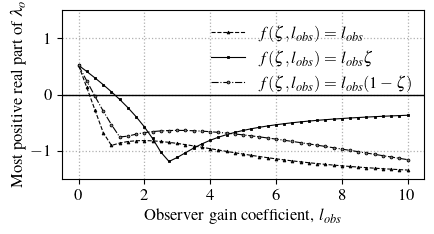

In [34]:
plt.rc('font', family='serif', serif='Times', size=12)
plt.rc('text', usetex=True)

# Create the plot
plt.figure(figsize=(4.5, 2.5))

# Plot with smaller and more subtle markers
plt.plot(l_obs_range, np.real(eigs_obs_L), label='$f(\zeta, l_{obs}) = l_{obs}$', marker='^', color='black', linestyle='--', linewidth=0.8, markersize=2, markerfacecolor='black', markeredgewidth=0.6)
plt.plot(l_obs_range, np.real(eigs_obs_Lz), label='$f(\zeta, l_{obs}) = l_{obs} \zeta$', marker='s', color='black', linestyle='-', linewidth=0.8, markersize=2, markerfacecolor='black', markeredgewidth=0.6)
plt.plot(l_obs_range, np.real(eigs_obs_Lz2), label='$f(\zeta, l_{obs}) = l_{obs} (1-\zeta)$', marker='.', color='black', linestyle='-.', linewidth=0.8, markersize=4, markerfacecolor='grey', markeredgewidth=0.6)

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.ylim(-1.5, 1.5)
# Add labels and grid
plt.xlabel('Observer gain coefficient, $l_{obs}$')
plt.ylabel('Most positive real part of $\lambda_o$')
# plt.title('Real Part of Eigenvalues vs. Observation Range', fontsize=10)
plt.legend(loc='upper right', frameon=False)

plt.grid(True, linestyle=':', linewidth=0.9)

# Adjust the layout for tight fit
plt.tight_layout()
plt.savefig('obs_lambda.svg', format='svg', bbox_inches='tight', pad_inches=0.5)

# Display the plot
plt.show()